# Cortical network model

Analysis of 2 and 3-population cortical network models with a focus on the effect of the synaptic strength on the network dynamics evoked by a stimulus

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Internal modules
from logger import logger
from network_model import *
from utils import *
from fileops import get_data_root, get_output_equivalent, load_lineagg_data, save_figs_book
from constants import *
from batchutils import *
from plotters import plot_table, harmonize_axes_limits
from postpro import get_fit_table, get_change_key, get_propagg_keys, compute_predictor

# Initialize empty figures dictionary
figs = {}

# Set up logging folder
logdir = get_output_equivalent(get_data_root(), 'raw', 'model')

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
layer = None  # cortical layer
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
errprop = 'inter'

### Derived parameters

In [4]:
# Get batch-related settings
_, input_dir, figsdir, _ = get_batch_settings(
    analysis_type, None, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

 2024/04/10 18:11:04: assembling batch analysis settings...


### Input summary table figure

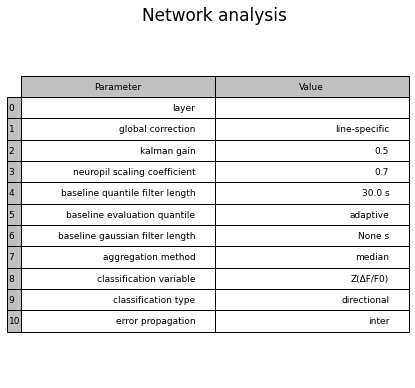

In [5]:
figs['dataset_info'] = plot_table({
    'layer': layer,
    'global correction': 'line-specific' if isinstance(global_correction, dict) else global_correction,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'error propagation': errprop,
    }, title='Network analysis', aspect=1.5)

### Load data and compute raw response profiles

 2024/04/10 18:11:09: loading line-average data (with inter-propagated SE)
 2024/04/10 18:11:09: loading line3 data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main folder
 2024/04/10 18:11:09: loading sst data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main folder
 2024/04/10 18:11:09: loading pv data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_9->10every100/main folder
 2024/04/10 18:11:09: loading sarah_line3 data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V

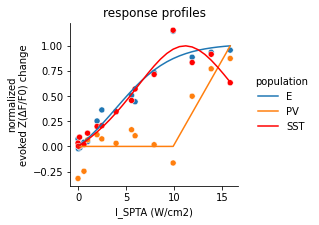

In [6]:
# Load line-aggregated stats
stats, counts = load_lineagg_data(input_dir, errprop=errprop)

# Restrict to 'all' responses
isall = stats.index.get_level_values(Label.ROI_RESP_TYPE) == 'all'
stats = (
    stats[isall]
    .droplevel(Label.ROI_RESP_TYPE)
    .reset_index(Label.RUN, drop=True)
)

# Extract data for responses of interest
xkey = Label.ISPTA
ykey = Label.ZSCORE
ykey_diff = get_change_key(ykey)
ykey_diff_prop = get_propagg_keys(ykey_diff)[0]
resp_data = (
    stats[[Label.ISPTA, ykey_diff_prop]]
    .rename(columns={ykey_diff_prop: ykey_diff})
    .set_index(Label.ISPTA, append=True)
    [ykey_diff]
)

# Fit response data
fit_dict = get_fit_table().loc[xkey]
predictors = {}
for pop, resp in resp_data.groupby(Label.LINE):
    predictors[pop] = compute_predictor(
        resp.droplevel(Label.LINE).index.values, 
        resp.values, 
        fit_dict.loc[pop])

# Compute fit profiles over dense input range
xbounds = np.sort(resp_data.index.unique(xkey))[[0, -1]]
xdense = np.linspace(*xbounds, 25)
resp_profiles = pd.DataFrame(index=pd.Index(xdense, name=xkey))
for pop, pred in predictors.items():
    resp_profiles[pop] = pred(xdense)
resp_profiles = (
    resp_profiles
    .stack()
    .rename_axis(index={None: Label.LINE})
    .swaplevel()
    .sort_index()
    .rename(ykey_diff)
)

# Apply lines->populations mapping
newobjs = []
for s in resp_profiles, resp_data:
    s = s.reset_index(level=Label.LINE)
    s[Label.LINE] = s[Label.LINE].str.replace('line3', 'e').str.upper()
    s['population'] = s.pop(Label.LINE)
    s = s.set_index('population', append=True).swaplevel().sort_index()[ykey_diff]
    newobjs.append(s)
resp_profiles, resp_data = newobjs

# Normalize response data
logger.info('normalizing predictors to [0, 1] range')
resp_bounds = resp_profiles.abs().groupby('population').agg(['min', 'max'])#.droplevel(0, axis=0)
resp_ranges = resp_bounds.diff(axis=1).iloc[:, 1].rename('range')
ykey_diff = f'normalized\n{ykey_diff}'
resp_data = ((resp_data - resp_bounds['min']) / resp_ranges).rename(ykey_diff)
resp_profiles = ((resp_profiles - resp_bounds['min']) / resp_ranges).rename(ykey_diff)

# Plot response profiles
figs['resp_profiles'], ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
pltkwargs = dict(
    ax=ax,
    x=xkey, 
    y=ykey_diff,
    hue='population',
    palette=NetworkModel.palette,
)
sns.scatterplot(data=resp_data.reset_index(), legend=False, **pltkwargs)
sns.lineplot(data=resp_profiles.reset_index(), **pltkwargs)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
ax.set_title('response profiles');

### Transform response profiles to network input amplitude space

 2024/04/10 18:11:12: (ISPTA -> amp) conversion factor: 3.00
 2024/04/10 18:11:12: vector ranges
     I_SPTA (W/cm2)  amplitude
min         0.00000   0.000000
max        15.82758  47.482741
 2024/04/10 18:11:12: saving reference profiles to CSV file


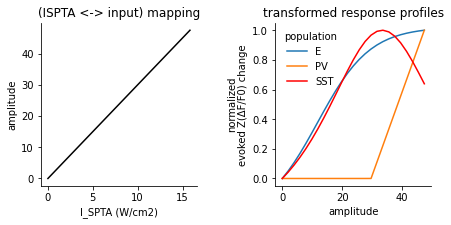

In [7]:
# Define "equivalent" ISPTA and input amplitude doses
ref_ISPTA = 10  # W/cm2
ref_amp = 30  # (-)

# Compute (ISPTA -> amplitude) conversion factor
ISPTA_to_amp = ref_amp / ref_ISPTA  # W/cm2 to (-)
logger.info(f'(ISPTA -> amp) conversion factor: {ISPTA_to_amp:.2f}')

# Compute ISPTA and equivalent input dose vectors
amp_key = 'amplitude'
eqvecs = pd.DataFrame({
    Label.ISPTA: xdense,
    amp_key: xdense * ISPTA_to_amp}
)
logger.info(f'vector ranges\n{eqvecs.agg(["min", "max"])}')

# Compute transformed response profiles in input space
transformed_resp_profiles = resp_profiles.reset_index()
transformed_resp_profiles[amp_key] = transformed_resp_profiles[Label.ISPTA] * ISPTA_to_amp
transformed_resp_profiles = transformed_resp_profiles.set_index(['population', amp_key])[ykey_diff]

# Plot ISPTA - input mapping and transformed response profiles
figs['transformed_resp_profiles'], axes = plt.subplots(1, 2, figsize=(7, 3))
figs['transformed_resp_profiles'].subplots_adjust(wspace=0.5)
for ax in axes:
    sns.despine(ax=ax)
axiter = iter(axes)
ax = next(axiter)
ax.set_title('(ISPTA <-> input) mapping')
sns.lineplot(
    ax=ax,
    data=eqvecs,
    x=Label.ISPTA, 
    y=amp_key,
    color='k'
)
ax = next(axiter)
sns.lineplot(
    ax=ax,
    data=transformed_resp_profiles.reset_index(),
    x=amp_key, 
    y=ykey_diff,
    hue='population',
    palette=NetworkModel.palette,
)
sns.move_legend(ax, loc='upper left', frameon=False)
ax.set_title('transformed response profiles')

# Reference activation profiles
ref_profiles = transformed_resp_profiles.unstack('population')
logger.info('saving reference profiles to CSV file')
ref_fpath = os.path.join(logdir, 'ref_profiles.csv')
if not os.path.exists(ref_fpath):
    ref_profiles.to_csv(ref_fpath)

# Extract input amplitudes from reference profiles
amps = ref_profiles.index.values


## Literature review

### Firing rate adaptation time constants

 2024/04/10 18:11:15: initialized NetworkModel(E, PV, SST)


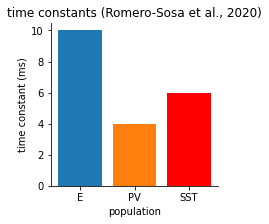

In [8]:
# Time constants (from Romero-Sosa et al. 2020)
tau = pd.Series(
    data={
        'E': 0.010, 
        'PV': .004, 
        'SST': .006
    },
    name='tau (s)'
)
populations = tau.index

figs['time constants'] = NetworkModel(tau=tau).plot_time_constants(
    suffix='Romero-Sosa et al., 2020')

### Gain functions

 2024/04/10 18:11:17: initialized NetworkModel(E, PV, SST)


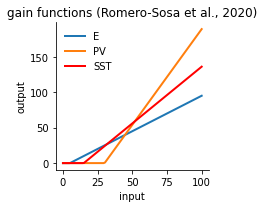

In [9]:
# Gain functions from Romero-Sosa et al. 2020
fgain = threshold_linear
fparams = pd.DataFrame(
    data={
        'x0': [5, 30, 15],  # E, PV, SST
        'A': [1, 2.7, 1.6], # E, PV, SST
    },
    index=pd.Index(populations, name='population'),
)

figs['fgain'] = NetworkModel(fgain=fgain, fparams=fparams).plot_fgain(
    suffix='Romero-Sosa et al., 2020')

### Network connectivity matrices

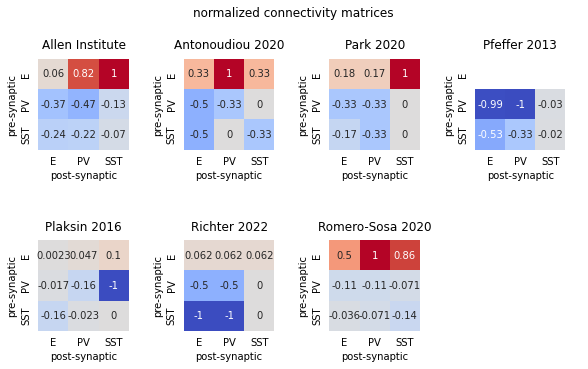

In [10]:
# Connectivity matrix (from Pfeffer et al. 2013)
W_pfeffer = pd.DataFrame(
    data=[
        [np.nan, np.nan, np.nan], # E -> E, PV, SST 
        [-1, -1.01, -0.03],  # PV -> E, PV, SST
        [-0.54, -0.33, -0.02]  # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Plaksin et al. 2016)
W_plaksin = pd.DataFrame(
    data=[
        [0.002, 0.04, 0.09],      # E -> E, PV, SST 
        [-0.015, -0.135, -0.86],  # PV -> E, PV, SST
        [-0.135, -0.02, 0]        # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Park et al. 2020)
W_park = pd.DataFrame(
    data=[
        [1.1, 1, 6],  # E -> E, PV, SST 
        [-2, -2, 0],  # PV -> E, PV, SST
        [-1, -2, 0]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Antonoudiou et al. 2020)
W_antonoudiou = pd.DataFrame(
    data=[
        [10, 30, 10],   # E -> E, PV, SST 
        [-15, -10, 0],  # PV -> E, PV, SST
        [-15, 0, -10]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Romero-Sosa et al. 2020, Figure 6A,B)
W_romero_sosa = pd.DataFrame(
    data=[
        [7, 14, 12],   # E -> E, PV, SST 
        [-1.5, -1.5, -1],  # PV -> E, PV, SST
        [-0.5, -1, -2]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Richter et al. 2022)
W_richter = pd.DataFrame(
    data=[
        [0.1, 0.1, 0.1],   # E -> E, PV, SST 
        [-0.8, -0.8, 0],  # PV -> E, PV, SST
        [-1.6, -1.6, 0]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Allen Brain Atlas)
W_allen = pd.DataFrame(
    data=[
        [ 0.06, 0.82, 1.],   # E -> E, PV, SST 
        [-0.37, -0.47, -0.13],  # PV -> E, PV, SST
        [-0.24, -0.22, -0.07],   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Assemble into dictionary
Wdict = pd.concat({
    'Pfeffer 2013': W_pfeffer,
    'Plaksin 2016': W_plaksin,
    'Antonoudiou 2020': W_antonoudiou,
    'Park 2020': W_park,
    'Romero-Sosa 2020': W_romero_sosa,
    'Richter 2022': W_richter,
    'Allen Institute': W_allen, 
}, axis=0, names=['source'])

# Comparative plot of connectivity matrices
figs['connectivity comparisons'] = NetworkModel.plot_connectivity_matrix(
    Wdict, norm=True)

### Define reference stimulus and amplitudes sweep vector

In [11]:
# Define relative amplitudes of external input per population for reference simulations
srel = pd.Series(1., index=populations, name='external input')  # relative input strength
Ithr = fparams.loc['E', 'x0']  # E activation threshold
s = 1.2 * Ithr * srel
logger.info(f'reference external input:\n{s}')

# Extract input amplitudes from reference profiles
amps = ref_profiles.index.values
logger.info(f'vector of extenral amplitudes: \n{amps}')

 2024/04/10 18:11:24: reference external input:
E      6.0
PV     6.0
SST    6.0
Name: external input, dtype: float64
 2024/04/10 18:11:24: vector of extenral amplitudes: 
[ 0.          1.97844753  3.95689507  5.9353426   7.91379014  9.89223767
 11.87068521 13.84913274 15.82758028 17.80602782 19.78447535 21.76292288
 23.74137042 25.71981795 27.69826549 29.67671302 31.65516056 33.63360809
 35.61205563 37.59050316 39.5689507  41.54739823 43.52584577 45.5042933
 47.48274084]


### Model optimization / comparison strategy

In [18]:
# Determine whether to normalize activation profiles
norm = True

# Whether to penalize disparities in response profiles
penalize_disparity = False

# Relative perturbations for model sensitivity analysis
rel_perturbation = 0.1

## 2-population (E, SST) model 

### Define model

 2024/04/10 18:11:27: initialized NetworkModel(E, SST)


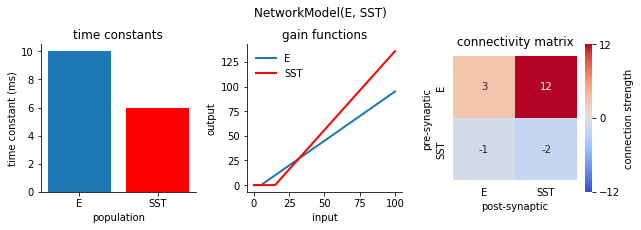

In [13]:
# Connectivity matrix
W2 = pd.DataFrame(
    data=[
        [3, 12],   # E -> E, SST
        [-1, -2]   # SST -> E, SST
    ], 
    index=pd.Index(['E', 'SST'], name='pre-synaptic'), 
    columns=pd.Index(['E', 'SST'], name='post-synaptic')
)

# Initialize model
model2 = NetworkModel(
    W=W2, 
    tau=tau.drop('PV'), 
    fgain=fgain, 
    fparams=fparams.drop('PV')
)

# Check balance of excitation vs inhibition
We = model2.get_net_excitation('SST')
Wi = model2.get_net_inhibition('SST')
if Wi < We:
    raise ValueError(f'net inhibition strength {Wi} < net excitation strength ({We})')

# Plot model2 summary
figs['2-pop model2'] = model2.plot_summary()

### Example simulation and stimulus amplitude sweep

 2024/04/10 18:11:30: NetworkModel(E, SST): running 0.5 s long simulation
 2024/04/10 18:11:30: simulation completed in 0.024 s
 2024/04/10 18:11:30: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 37.39it/s]


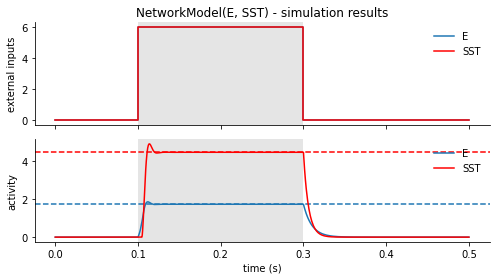

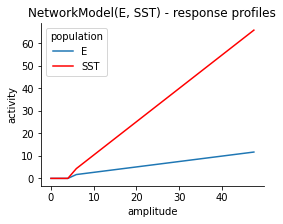

In [14]:
# Simulate model, and extract steady-state stimulus-evoked activity
data = model2.simulate(s=s.drop('PV'))
rss = model2.extract_steady_state(data)

# Plot results
figs['2-pop timeseries'] = model2.plot_timeseries(data, ss=rss)

# Simulate model for each amplitude
sweep_data = model2.run_stim_sweep(srel.drop('PV'), amps)

# Extract steady-state stimulus-evoked activity for each relative amplitude
sweep_rss = model2.extract_steady_state(sweep_data)
# Plot steady-state activity dependency on stimulus amplitude
figs['2-pop ss dep norm.'] = model2.plot_sweep_results(
    sweep_rss, title=f'{model2} - response profiles')

### Explore/optimize connectivity parameters

 2024/04/10 18:11:34: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-SST_threshold_linear_fparams844eb9549d1762eb2940037d4bc00ed4_tauE0.01SST0.006_srelE1.0SST1.0_targets5e4d1dc5368fc89e44b94f71b4fbec16_diffev_norm.csv
 2024/04/10 18:11:34: optimal connectivity matrix:
post-synaptic          E        SST
pre-synaptic                       
E              11.031843  18.213323
SST           -12.958390 -16.795699
 2024/04/10 18:11:34: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 30.10it/s]


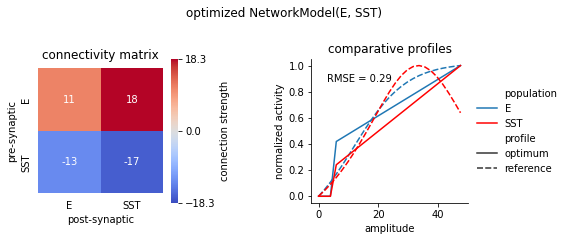

In [15]:
# Define optimization parameters
optargs, optkwargs = (
    [model2, srel.drop('PV'), ref_profiles.drop('PV', axis=1)],
    dict(
        norm=norm, 
        logdir=logdir,
        mpi=True,
    )
)

# Optimize connectivity matrix to minimize divergence with reference profiles
W2opt = ModelOptimizer.optimize(*optargs, **optkwargs)

# Perform stimulus sweep with optimal connectivity matrix
logger.info(f'optimal connectivity matrix:\n{W2opt}')
model2.W = W2opt
sweep_data = model2.run_stim_sweep(srel.drop('PV'), amps)
sweep_rss = model2.extract_steady_state(sweep_data)

# Compare results to reference profiles
rmse = model2.evaluate_stim_sweep(ref_profiles.drop('PV', axis=1), sweep_data, norm=norm)
sweep_comp = pd.concat({
    'optimum': sweep_rss,
    'reference': ref_profiles.drop('PV', axis=1)
}, axis=0, names=['profile'])

# Plot results
figs['2-pop opt'], axes = plt.subplots(1, 2, figsize=(8, 3))
model2.plot_connectivity_matrix(W=W2opt, ax=axes[0])
ax = axes[1]
model2.plot_sweep_results(sweep_comp, norm=norm, ax=ax, style='profile')
sns.move_legend(ax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)
ax.set_title(f'comparative profiles')
ax.text(0.1, 0.9, f'RMSE = {rmse:.2f}', transform=ax.transAxes, ha='left', va='top')
figs['2-pop opt'].tight_layout()
figs['2-pop opt'].subplots_adjust(wspace=.75)
figs['2-pop opt'].suptitle(f'optimized {model2}', y=1.1);

## 3-population (E, SST, PV) model

### Define model

 2024/04/10 18:11:38: initialized NetworkModel(E, PV, SST)


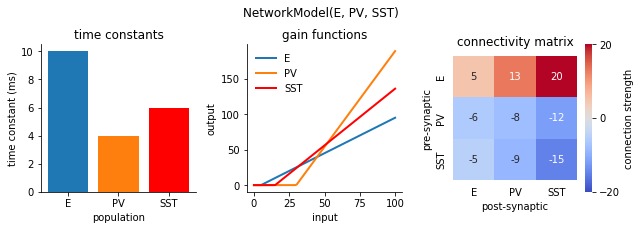

In [16]:
# Connectivity matrix
W3 = pd.DataFrame(
    data=[
        [5, 13, 20],   # E -> E, PV, SST
        [-6, -8, -12],  # PV -> E, PV, SST
        [-5, -9, -15]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Initialize model
model3 = NetworkModel(
    W=W3, 
    tau=tau, 
    fgain=fgain,
    fparams=fparams
)

# Plot model summary
figs['3-pop model'] = model3.plot_summary()    

### Example simulation and stimulus amplitude sweep

 2024/04/10 18:11:40: NetworkModel(E, PV, SST): running 0.5 s long simulation
 2024/04/10 18:11:40: simulation completed in 0.027 s
 2024/04/10 18:11:41: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 27.25it/s]


 2024/04/10 18:11:42: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 27.14it/s]

 2024/04/10 18:11:43: NetworkModel(E, PV, SST): evaluating sensitivity to connectivity perturbations


 2024/04/10 18:11:43: relative perturbation: -10.0%


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]

 2024/04/10 18:11:52: relative perturbation: 10.0%



100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


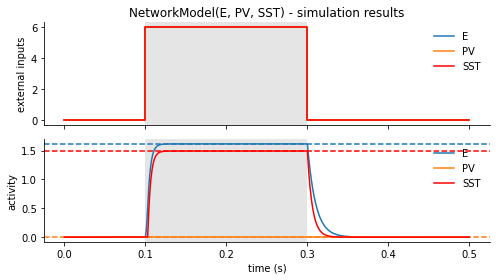

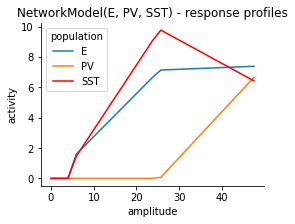

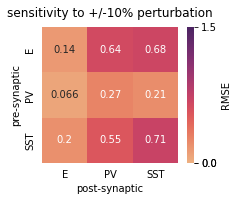

In [17]:
# Simulate model, and extract steady-state stimulus-evoked activity
data = model3.simulate(s=s)
try:
    rss = model3.extract_steady_state(data)
except MetricError as e:
    logger.error(e)
    rss = None

# Plot results
figs['3-pop timeseries'] = model3.plot_timeseries(data, ss=rss)

# Simulate model for each amplitude
sweep_data = model3.run_stim_sweep(srel, amps)
# Extract steady-state stimulus-evoked activity for each relative amplitude
sweep_rss = model3.extract_steady_state(sweep_data)
# Plot steady-state activity dependency on stimulus amplitude
figs['3-pop ss dep norm.'] = model3.plot_sweep_results(
    sweep_rss, title=f'{model3} - response profiles')

# Evaluate sensitivity to network connectivity perturbations
Wsensitivity = model3.evaluate_sensitivity(
    srel, amps, rel_perturbation=rel_perturbation, norm=norm)
figs['3-pop sensitivity'] = model3.plot_connectivity_matrix(
    W=Wsensitivity, title=f'sensitivity to +/-{rel_perturbation * 1e2:.0f}% perturbation', clabel='RMSE');

### Explore/optimize connectivity parameters

 2024/04/10 18:16:05: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparams811f5d27f5f880e6a7656fd9236b94d2_tauE0.01PV0.004SST0.006_srelE1.0PV1.0SST1.0_targets79e907befba8d9f11ceb6bea5923b7f7_diffev_norm.csv
 2024/04/10 18:16:05: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparams811f5d27f5f880e6a7656fd9236b94d2_tauE0.01PV0.004SST0.006_srelE1.0PV1.0SST1.0_targets79e907befba8d9f11ceb6bea5923b7f7_diffev_norm_rerun1.csv
 2024/04/10 18:16:05: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparams811f5d27f5f880e6a7656fd9236b94d2_tauE0.01PV0.004SST0.006_srelE1.0PV1.0SST1.0_targets79e907befba8d9f11ceb6bea5923b7f7_diffev_norm_rerun2.csv
 2024/04/10 18:16:05: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparams811f5d27f5f880e6a7656fd9236b94d2_tauE0.01PV0.004SST0.006_srelE1.0PV1.0SST1.

100%|██████████| 25/25 [00:00<00:00, 28.89it/s]


 2024/04/10 18:16:10: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 30.36it/s]


 2024/04/10 18:16:11: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 28.58it/s]


 2024/04/10 18:16:14: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 29.01it/s]


 2024/04/10 18:16:15: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 29.64it/s]


Text(0.5, 1.004, 'NetworkModel(E, PV, SST) optimization')

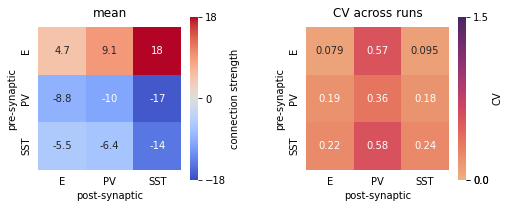

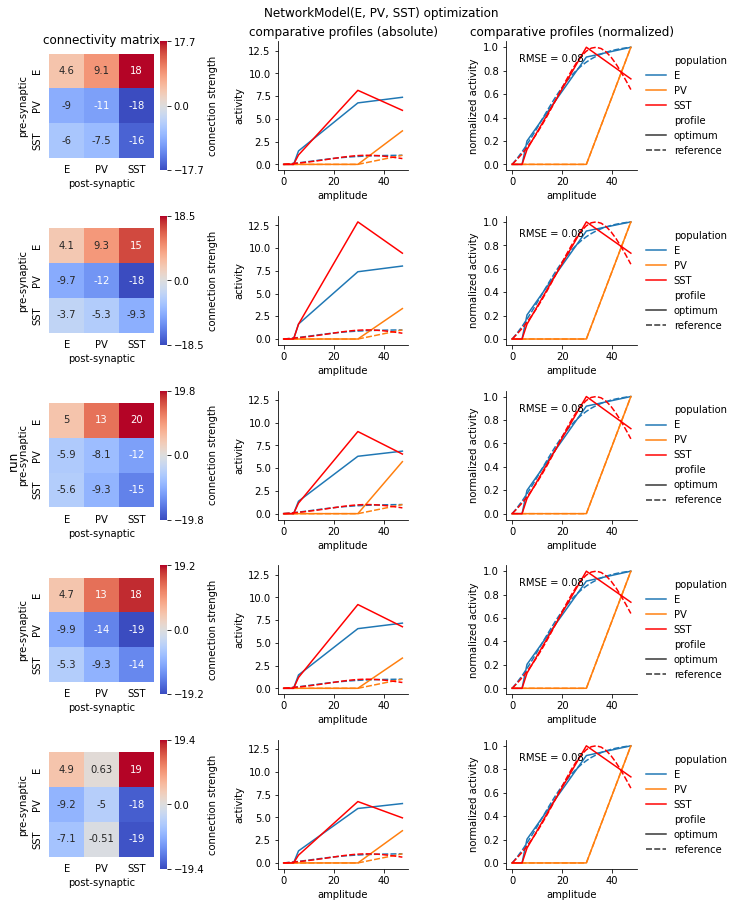

In [20]:
# # Adjust gains
# fparams_uniform = model3.fparams.copy()
# for k in fparams_uniform.index:
#     fparams_uniform.loc[k] = fparams_uniform.loc['E']
# model3.fparams = fparams_uniform

# Set constraints on connectivity matrix
# Wbounds = model3.get_coupling_bounds()
# Wbounds.loc['SST', 'SST'] = (0, 0)
# Wbounds = model3.get_coupling_bounds(wmax=10)
Wbounds = None

# Define optimization parameters
optargs, optkwargs = (
    [model3, srel, ref_profiles],
    dict(
        norm=norm, 
        penalize_disparity=penalize_disparity,
        logdir=logdir,
        mpi=True,
        Wbounds=Wbounds,
    )
)

# # Optimize connectivity matrix to minimize divergence with reference profiles
# W3opt = ModelOptimizer.optimize(*optargs, **optkwargs)

# Load and plot optimization history
histories = ModelOptimizer.load_optimization_history(*optargs, **optkwargs)
if 'run' not in histories.index.names:
    histories = pd.concat({0: histories}, names=['run'])
has_converged = ModelOptimizer.has_optimization_converged(histories)
for irun, converged in has_converged.items():
    if not converged:
        logger.warning(f'optimization did not converge for run {irun}')

# Extract optimum connectivity matrix from each run and associated cost
optimums = ModelOptimizer.extract_optimum(histories)
W3opts = model3.Wvec_to_Wmat(optimums)

# Plot similarity between connectivity matrices from different runs
figs['3pop convergence'] = model3.plot_connectivity_matrix(W3opts, agg=True)

# Create figure
figkey = '3-pop opt'
nruns = len(optimums)
figs[figkey], axes = plt.subplots(nruns, 3, figsize=(10, 2.5 * nruns))
axes = np.atleast_2d(axes)

# For each run, perform stimulus sweep with optimal connectivity matrix
for irow, (axrow, (irun, W3opt)) in enumerate(zip(axes, W3opts.groupby('run'))):
    W3opt = W3opt.droplevel('run')

    model3.W = W3opt
    sweep_data = model3.run_stim_sweep(srel, amps)
    sweep_rss = model3.extract_steady_state(sweep_data)

    # Compare results to reference profiles
    rmse = model3.evaluate_stim_sweep(
        ref_profiles, sweep_data, norm=norm, penalize_disparity=penalize_disparity)
    sweep_comp = pd.concat({
        'optimum': sweep_rss,
        'reference': ref_profiles
    }, axis=0, names=['profile'])

    # Plot results
    model3.plot_connectivity_matrix(W=W3opt, ax=axrow[0], title=None if irow == 0 else '')
    for ax, n in zip(axrow[1:], [False, True]):
        model3.plot_sweep_results(sweep_comp, norm=n, ax=ax, style='profile')
        if irow == 0:
            ax.set_title(f'comparative profiles {"(normalized)" if n else "(absolute)"}')
        if not n:
            ax.get_legend().remove()
        if n == norm:
            ax.text(0.1, 0.9, f'RMSE = {rmse:.2f}', transform=ax.transAxes, ha='left', va='top')
    sns.move_legend(ax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)

# Harmonize axes limits for absolute profiles
harmonize_axes_limits(axes[:, 1], 'y')

# Adjust layout
figs[figkey].tight_layout()
figs[figkey].supylabel('run', x=-0.02)
figs[figkey].subplots_adjust(wspace=.75)
figs[figkey].suptitle(f'{model3} optimization', y=1 + 0.02 / nruns)

# Evaluate sensitivity to network connectivity perturbations
model3.W = W3opts.groupby('pre-synaptic').mean()
Wsensitivity = model3.evaluate_sensitivity(
    srel, amps, rel_perturbation=rel_perturbation, norm=norm, penalize_disparity=penalize_disparity)
figs['3-pop opt sensitivity'] = model3.plot_connectivity_matrix(
    W=Wsensitivity, title=f'sensitivity to +/-{rel_perturbation * 1e2:.0f}% perturbation', clabel='RMSE');

### Save figures

In [27]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix='network_model')

 2024/04/09 15:12:57: saving figures in /gpfs/scratch/lemait01/data/usnm/figs/2024.04.09/figs_network_model.pdf:


100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
